In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial
import time

In [2]:
class KMeans:
    def __init__(self, X, k=5, max_iterations=100, init_centroids=[], distance_func="euclidean", labels=[], terminating_condition="converged"):
        self.k = k
        self.max_iterations = max_iterations
        self.centroids = init_centroids
        self.clusters = [[] for _ in range(self.k)]
        self.distance_func = distance_func
        self.X = X
        self.sample_count, self.feature_count = X.shape
        self.labels = labels
        self.time = 0
        self.iteration_count = 0
        self.terminating_condition = terminating_condition
    
    def _distance(self, x1, x2):
        if self.distance_func == "euclidean":
            return spatial.distance.euclidean(x1, x2)
        if self.distance_func == "manhattan":
            return spatial.distance.cityblock(x1, x2)
        if self.distance_func == "cosine":
            return spatial.distance.cosine(x1, x2) #This corresponds to 1 - cosine_similarity
        if self.distance_func == "jaccard":
            return 1 - (np.sum(np.minimum(x1, x2), axis=0) / np.sum(np.maximum(x1, x2), axis=0))
        
    def _create_clusters(self, centroids):
        clusters = [[] for _ in range(self.k)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._get_closest_cluster(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters
    
    def _get_closest_cluster(self, sample, centroids):
        #print("get closest cluster")
        #print("gcc sample "+str(sample))
        #print("gcc centroids "+str(centroids))
        distances = [self._distance(sample, centroid) for centroid in centroids]
        return np.argmin(distances)
    
    def _update_centroids(self, clusters):
        #print("Update centroids")
        new_centroids = np.zeros((self.k, self.feature_count))
        #print("init new centroids "+str(new_centroids))
        for cluster_index, cluster in enumerate(clusters):
            #print("Cluster index: "+str(cluster_index))
            #print("Cluster "+str(cluster))
            cluster_mean = np.mean(self.X[cluster], axis=0)
            #print("cluster mean "+str(cluster_mean))
            new_centroids[cluster_index] = cluster_mean
            #print("new ce3ntroids "+str(new_centroids))
        return new_centroids

    def _is_converged(self):
        distances = [self._distance(self.prev_centroids[i], self.centroids[i]) for i in range(self.k)]
        return sum(distances) == 0
    
    def _check_terminating_condition(self):
        if self.terminating_condition == "converged":
            return self._is_converged()
        if self.terminating_condition == "sse":
            return self.computeWithinss(self.centroids) > self.computeWithinss(self.prev_centroids) or self.iteration_count >= self.max_iterations
        if self.terminating_condition == "preset_max":
            return self.iteration_count >= self.max_iterations
    
    def get_cluster_labels(self):
        labels = np.empty(self.sample_count)
        for cluster_index, cluster in enumerate(self.clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_index
        return labels
        
    def iterate(self):
        self.iteration_count += 1
        # Update clusters
        self.clusters = self._create_clusters(self.centroids)

        # Update centroids
        self.prev_centroids = self.centroids
        self.centroids = self._update_centroids(self.clusters)
        
    def predict(self):
        start = time.perf_counter()
        if len(self.centroids) == 0:
            random_sample = np.random.choice(self.sample_count, self.k, replace=False)
            self.centroids = [self.X[i] for i in random_sample]
        
        converged = False
        while self.iteration_count == 0 or not self._check_terminating_condition():
            self.iterate()
                
        print("Terminated after "+str(self.iteration_count))
        if self.terminating_condition == "sse":
                    self.centroids = self.prev_centroids
        end = time.perf_counter()
        self.time = end - start
            
    def plot(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        
        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)
            
        for point in self.centroids:
            ax.scatter(*point, marker="x", color="black", linewidth=3)
        
        plt.show()
        
    def computeWithinss(self, centroids=[]):
        if len(centroids) == 0:
            centroids = self.centroids
        result = 0
        for i, centroid in enumerate(centroids):
            for point_index in self.clusters[i]:
                point = self.X[point_index]
                result += spatial.distance.euclidean(centroid, point)
        return result
    
    def computeAccuracy(self):
        if len(self.labels) == 0:
            print("No class labels provided to compute accuracy")
        # Get cluster label corresponding to class by majority vote
        class_labels = np.unique(self.labels)
        cluster_labels = self.get_cluster_labels()
        class_cluster_labels = [[] for _ in range(len(class_labels))]
        majority_vote_class_label = []
        for i, class_label in enumerate(class_labels):
            mask = iris_labels == class_label
            class_cluster_labels[i] = cluster_labels[mask]

        for i, class_cluster_label in enumerate(class_cluster_labels):
            majority_vote_class_label.append(np.argmax(np.bincount(class_cluster_label.astype(int))))

        # Compute accuracy
        misclassifications = 0
        for i, class_cluster_label in enumerate(class_cluster_labels):
            misclassifications += np.count_nonzero(class_cluster_label != majority_vote_class_label[i])

        accuracy = 1 - (misclassifications / len(cluster_labels))
        return accuracy
    
    def getTime(self):
        return self.time
    
    def getIterCount(self):
        return self.iteration_count
            

In [3]:
football = pd.read_csv("../data/footballClustering/footballClustering.csv")
data = football[["Wins2016", "Wins2017"]]
data = data.loc[data.Wins2016.notna()]
data = data.values

In [4]:
print(data)

[[3. 5.]
 [3. 4.]
 [2. 8.]
 [2. 3.]
 [6. 2.]
 [6. 4.]
 [7. 3.]
 [7. 4.]
 [8. 5.]
 [7. 6.]]


In [5]:
kmeans = KMeans(data, k = 2)

In [6]:
kmeans.predict()

Terminated after 2


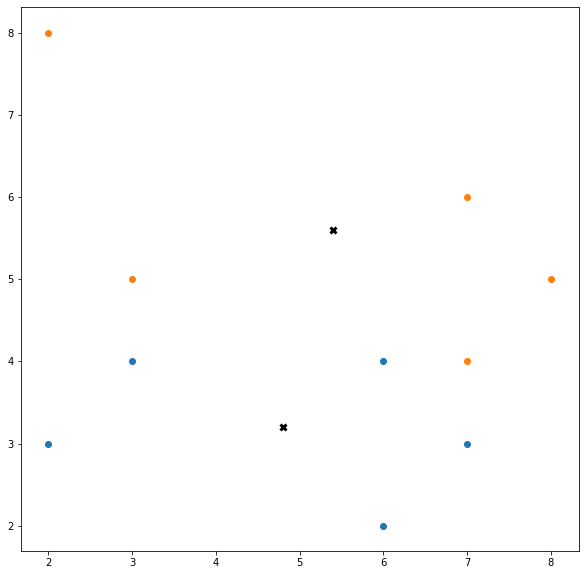

In [7]:
kmeans.plot()

In [8]:
kmeans.centroids

array([[4.8, 3.2],
       [5.4, 5.6]])

# 1.1 Manhattan Distance

In [9]:
centroids = [[4, 6], [5, 4]]
kmeans = KMeans(data, k = 2, init_centroids=centroids, distance_func="manhattan")

In [10]:
kmeans.iterate()

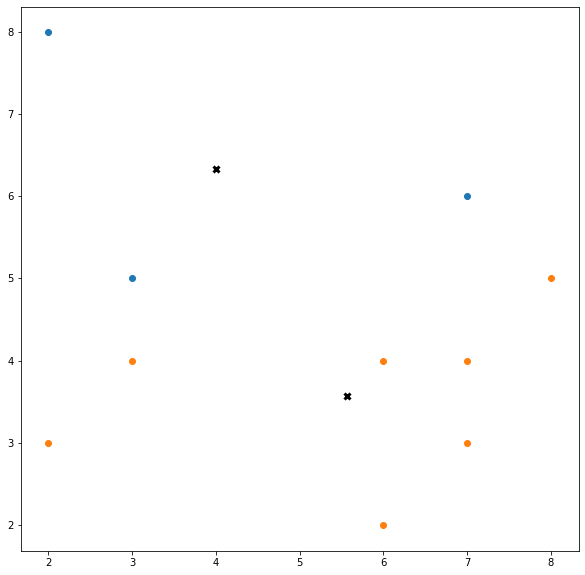

In [11]:
kmeans.plot()

In [12]:
kmeans.centroids

array([[4.        , 6.33333333],
       [5.57142857, 3.57142857]])

In [13]:
kmeans = KMeans(data, k = 2, init_centroids=centroids, distance_func="manhattan")
kmeans.predict()

Terminated after 2


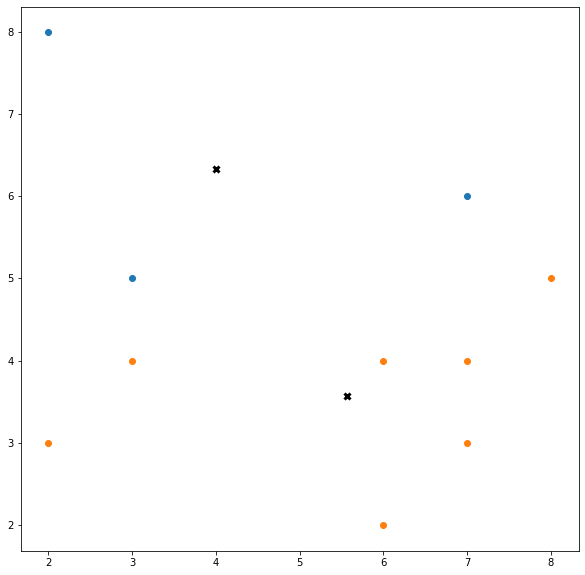

In [14]:
kmeans.plot()

# 1.2 Euclidean Distance

In [15]:
kmeans = KMeans(data, k = 2, init_centroids=centroids, distance_func="euclidean")

In [16]:
kmeans.iterate()

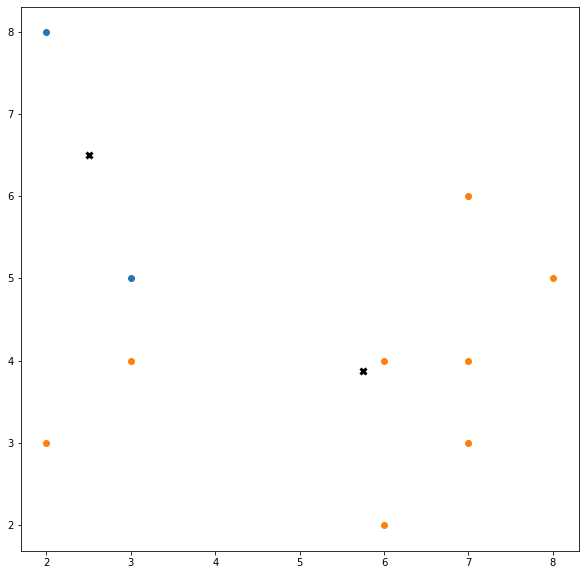

In [17]:
kmeans.plot()

In [18]:
kmeans.centroids

array([[2.5  , 6.5  ],
       [5.75 , 3.875]])

In [19]:
kmeans = KMeans(data, k = 2, init_centroids=centroids, distance_func="euclidean")
kmeans.predict()

Terminated after 3


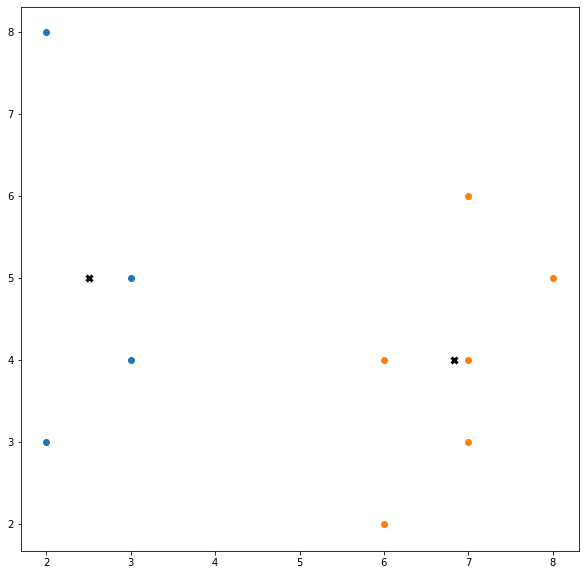

In [20]:
kmeans.plot()

# 1.3 Manhattan Distance 2

In [21]:
centroids = [[3, 3], [8, 3]]
kmeans = KMeans(data, k = 2, init_centroids=centroids, distance_func="manhattan")

In [22]:
kmeans.iterate()

In [23]:
kmeans.centroids

array([[2.5       , 5.        ],
       [6.83333333, 4.        ]])

In [24]:
centroids = [[3, 3], [8, 3]]
kmeans = KMeans(data, k = 2, init_centroids=centroids, distance_func="manhattan")

In [25]:
kmeans.predict()

Terminated after 2


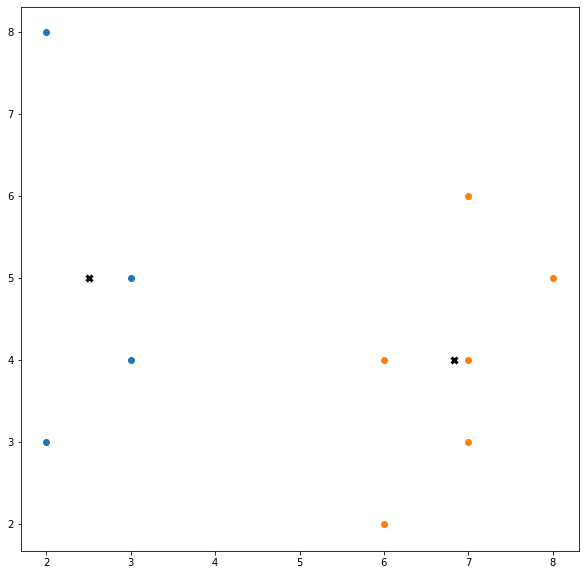

In [26]:
kmeans.plot()

# 1.4 Manhattan 3

In [27]:
centroids = [[3, 2], [4, 8]]
kmeans = KMeans(data, k = 2, init_centroids=centroids, distance_func="manhattan")

In [28]:
kmeans.iterate()

In [29]:
kmeans.centroids

array([[4.85714286, 3.57142857],
       [5.66666667, 6.33333333]])

In [30]:
kmeans = KMeans(data, k = 2, init_centroids=centroids, distance_func="manhattan")
kmeans.predict()

Terminated after 2


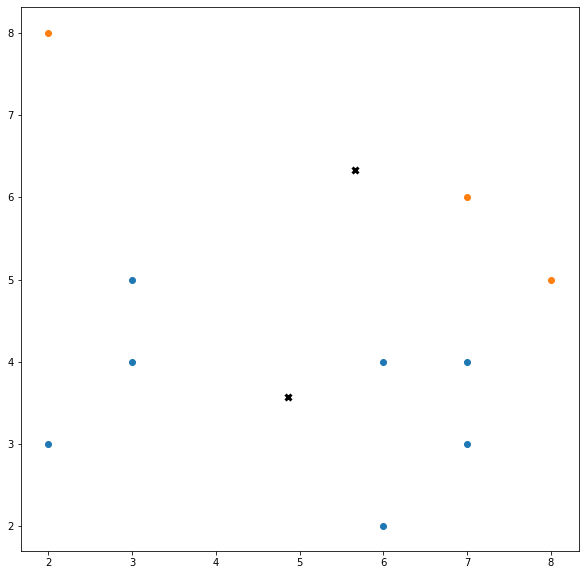

In [31]:
kmeans.plot()

# Task 2: Iris

In [32]:
iris = pd.read_csv("../data/iris/iris.csv", header=None)
iris.head()
iris_labels = iris.iloc[:,4].values
iris = iris[[0, 1, 2, 3]].values

# 2.1 SSE Comparison

In [33]:
kmeans_euclidean = KMeans(iris, k=3, distance_func="euclidean", labels=iris_labels)

In [34]:
kmeans_euclidean.predict()

Terminated after 6


In [35]:
kmeans_euclidean.computeWithinss()

97.32592423430009

In [36]:
kmeans_cosine = KMeans(iris, k=3, distance_func="cosine", labels=iris_labels)

In [37]:
kmeans_cosine.predict()

Terminated after 3


In [38]:
kmeans_cosine.computeWithinss()

101.57278954029861

In [39]:
kmeans_jaccard = KMeans(iris, k=3, distance_func="jaccard", labels=iris_labels)

In [40]:
kmeans_jaccard.predict()

Terminated after 12


In [41]:
kmeans_jaccard.computeWithinss()

97.48732751635758

In [42]:
kmeans_jaccard.get_cluster_labels()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2.,
       1., 2., 1., 2., 1., 2., 2., 1., 1., 2., 2., 2., 2., 2., 1., 1., 2.,
       2., 2., 1., 2., 2., 2., 1., 2., 2., 2., 1., 2., 2., 1.])

In [43]:
np.unique(iris_labels)

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

# Task 2.2 Accuracy Comparison

In [44]:
kmeans_euclidean.computeAccuracy()

0.8933333333333333

In [45]:
kmeans_cosine.computeAccuracy()

0.9733333333333334

In [46]:
kmeans_jaccard.computeAccuracy()

0.88

# Task 2.3 Performance Comparison

In [47]:
print(kmeans_euclidean.getIterCount())
print(kmeans_euclidean.getTime())

6
0.08069598199999994


In [48]:
print(kmeans_cosine.getIterCount())
print(kmeans_cosine.getTime())

3
0.09791788700000037


In [49]:
print(kmeans_jaccard.getIterCount())
print(kmeans_jaccard.getTime())

12
0.18944323400000052


# Task 2.4 Terminating Conditions

In [50]:
kmeans_euclidean_preset = KMeans(iris, k=3, distance_func="euclidean", labels=iris_labels, terminating_condition="preset_max")
kmeans_euclidean_sse = KMeans(iris, k=3, distance_func="euclidean", labels=iris_labels, terminating_condition="sse")
kmeans_cosine_preset = KMeans(iris, k=3, distance_func="cosine", labels=iris_labels, terminating_condition="preset_max")
kmeans_cosine_sse = KMeans(iris, k=3, distance_func="cosine", labels=iris_labels, terminating_condition="sse")
kmeans_jaccard_preset = KMeans(iris, k=3, distance_func="jaccard", labels=iris_labels, terminating_condition="preset_max")
kmeans_jaccard_sse = KMeans(iris, k=3, distance_func="jaccard", labels=iris_labels, terminating_condition="sse")

kmeans_euclidean_preset.predict()
kmeans_euclidean_sse.predict()
kmeans_cosine_preset.predict()
kmeans_cosine_sse.predict()
kmeans_jaccard_preset.predict()
kmeans_jaccard_sse.predict()

Terminated after 100
Terminated after 3
Terminated after 100
Terminated after 100
Terminated after 100
Terminated after 100


In [51]:
print(kmeans_euclidean_preset.getTime())
print(kmeans_euclidean_preset.getIterCount())
print(kmeans_euclidean_preset.computeWithinss())

1.055753888
100
97.34621969415679


In [52]:
print(kmeans_euclidean_sse.getTime())
print(kmeans_euclidean_sse.getIterCount())
print(kmeans_euclidean_sse.computeWithinss())

0.059868165999999334
3
97.44404944101123


In [53]:
print(kmeans_euclidean.getTime())
print(kmeans_euclidean.getIterCount())
print(kmeans_euclidean.computeWithinss())

0.08069598199999994
6
97.32592423430009


In [54]:
print(kmeans_cosine_preset.getTime())
print(kmeans_cosine_preset.getIterCount())
print(kmeans_cosine_preset.computeWithinss())

2.3318541019999994
100
101.57278954029852


In [66]:
kmeans_cosine_sse = KMeans(iris, k=3, distance_func="cosine", labels=iris_labels, terminating_condition="sse")
kmeans_cosine_sse.predict()
print(kmeans_cosine_sse.getTime())
print(kmeans_cosine_sse.getIterCount())
print(kmeans_cosine_sse.computeWithinss())

Terminated after 2
0.12113336999993862
2
125.63333167114233


In [56]:
print(kmeans_cosine.getTime())
print(kmeans_cosine.getIterCount())
print(kmeans_cosine.computeWithinss())

0.09791788700000037
3
101.57278954029861


In [57]:
print(kmeans_jaccard_preset.getTime())
print(kmeans_jaccard_preset.getIterCount())
print(kmeans_jaccard_preset.computeWithinss())

1.047397964
100
97.4873275163576


In [64]:
kmeans_jaccard_sse = KMeans(iris, k=3, distance_func="jaccard", labels=iris_labels, terminating_condition="sse")
kmeans_jaccard_sse.predict()
print(kmeans_jaccard_sse.getTime())
print(kmeans_jaccard_sse.getIterCount())
print(kmeans_jaccard_sse.computeWithinss())

Terminated after 3
0.08859588400002849
3
98.03749049590064


In [59]:
print(kmeans_jaccard.getTime())
print(kmeans_jaccard.getIterCount())
print(kmeans_jaccard.computeWithinss())

0.18944323400000052
12
97.48732751635758


# Task 4

In [67]:
triangle = [[4.7, 3.2], [4.9, 3.1], [5.0, 3.0], [4.6, 2.9]]
diamond = [[5.9, 3.2], [6.7, 3.1], [6.0, 3.0], [6.2, 2.8]]

In [68]:
dist = 0
for p1 in triangle:
    for p2 in diamond:
        dist += spatial.distance.euclidean(p1, p2)
print(dist/16)

1.4128564854895742
